In [122]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [123]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [124]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [125]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [126]:
tf.keras.backend.clear_session()

In [127]:
subject = 'Alagoas - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [128]:
data = pd.read_csv('2003_mo_model_input_AL.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - Consumo de Cimento (t),Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.635160,1.594356e+06,30.109,0.728082,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,2002.694978,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07,0.574004,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.635571,1.598004e+06,27.684,0.728532,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,2002.726142,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07,0.574517,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.635982,1.601652e+06,26.534,0.728982,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,2002.744322,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07,0.575030,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.636393,1.605299e+06,25.109,0.729432,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,2002.746270,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07,0.575544,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.636804,1.608947e+06,25.171,0.729882,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,2002.886466,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07,0.576057,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34203.746404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34166.160992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34117.245244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34053.559120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


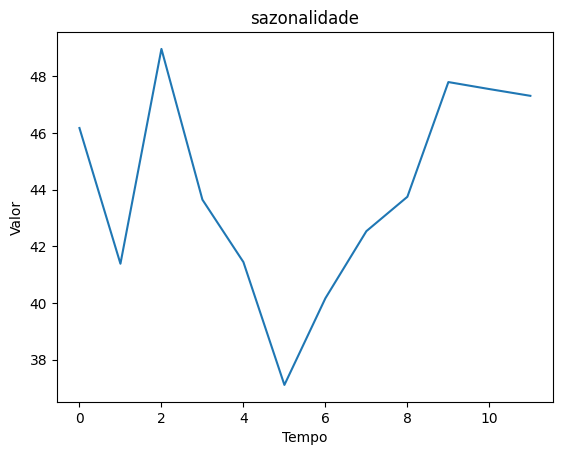

,sazonalidade
sazonalidade,
0,46.174340
1,41.382404
2,48.967201
3,43.643633
4,41.440538
5,37.102875
6,40.163254
7,42.532381
8,43.746386


In [129]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [130]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Alagoas - Consumo de Cimento (t)
0,2003-1,0.635160,1.594356e+06,0.728082,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,2002.694978,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07,0.574004,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,46.174340,30.109
1,2003-2,0.635571,1.598004e+06,0.728532,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,2002.726142,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07,0.574517,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,41.382404,27.684
2,2003-3,0.635982,1.601652e+06,0.728982,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,2002.744322,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07,0.575030,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,48.967201,26.534
3,2003-4,0.636393,1.605299e+06,0.729432,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,2002.746270,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07,0.575544,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,43.643633,25.109
4,2003-5,0.636804,1.608947e+06,0.729882,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,2002.886466,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07,0.576057,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,41.440538,25.171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34203.746404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.440538,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34166.160992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.102875,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34117.245244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.163254,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34053.559120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.532381,NaN


In [131]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      24.166
1      21.774
2      28.228
3      25.525
4      26.207
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Alagoas - Consumo de Cimento (t), Length: 249, dtype: float64

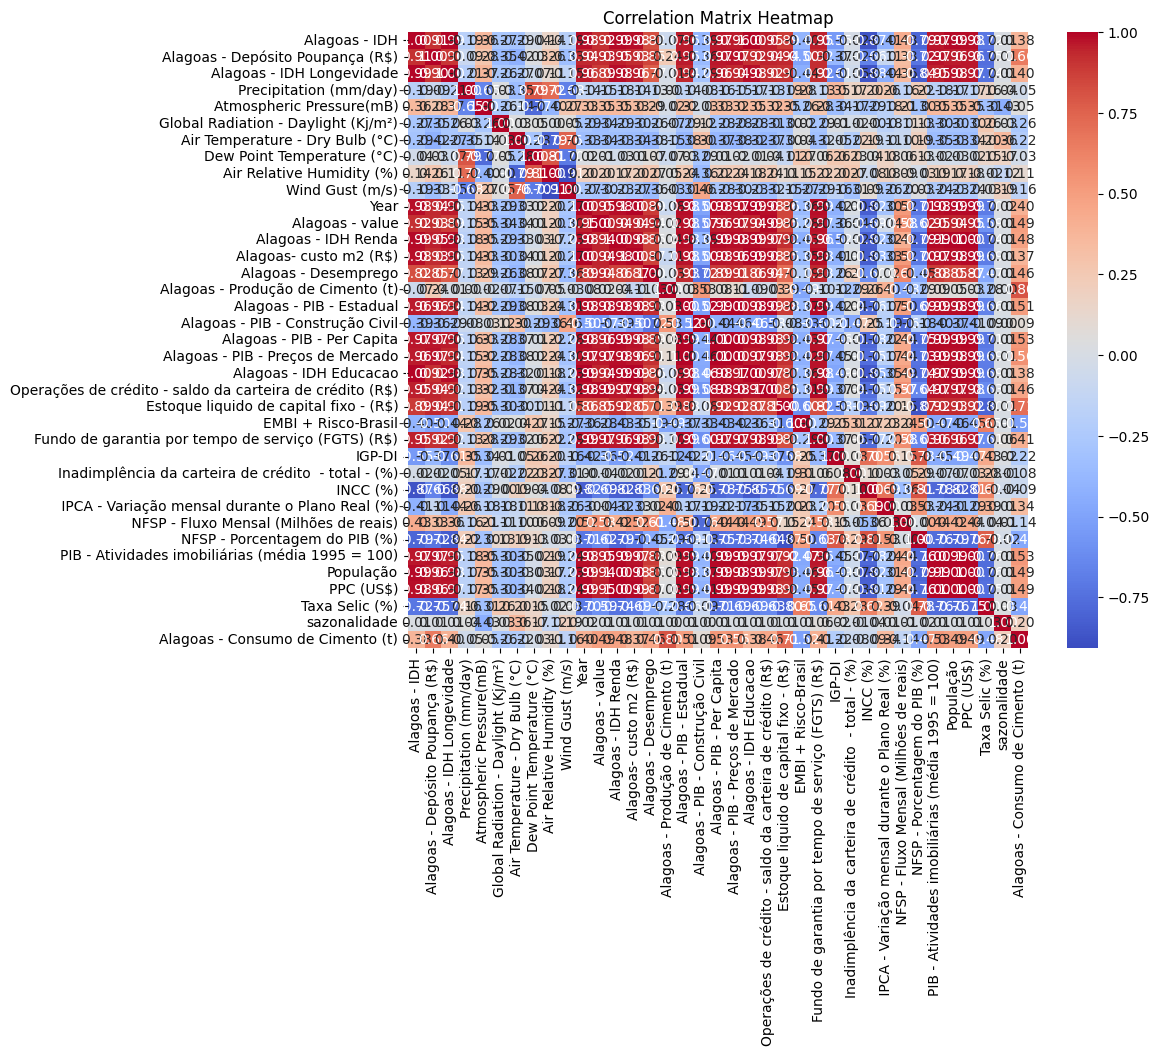

In [132]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [133]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [134]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Alagoas - IDH,1.635122e+10
1,Alagoas - Depósito Poupança (R$),1.077916e+05
2,Alagoas - IDH Longevidade,1.298863e+09
3,Precipitation (mm/day),2.021220e+02
4,Atmospheric Pressure(mB),2.404424e+07
5,Global Radiation - Daylight (Kj/m²),1.685199e+01
6,Air Temperature - Dry Bulb (°C),5.964382e+06
7,Dew Point Temperature (°C),4.438488e+06
8,Air Relative Humidity (%),3.094653e+06
9,Wind Gust (m/s),1.583021e+03


In [135]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


,Alagoas - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,1.594356e+06,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,2002.694978,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,0.574004,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,46.174340
1,1.598004e+06,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,2002.726142,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,0.574517,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,41.382404
2,1.601652e+06,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,2002.744322,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,0.575030,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,48.967201
3,1.605299e+06,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,2002.746270,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,0.575544,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,43.643633
4,1.608947e+06,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,2002.886466,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,0.576057,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,41.440538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,3.599068e+06,0.946579,1006.180976,1545.531388,24.936324,20.509629,77.572147,2.717020,2017.980331,0.457078,0.631370,24129.472843,13.987831,22.054199,3.120760e+07,1.304717e+06,0.644329,3.161173e+06,7.751979e+06,267.077474,9.671878e+06,0.616129,3.065096,0.365766,0.295704,2763.919661,2.182490,203.197885,1.996339e+08,427.801099,0.584520,42.532381
188,3.604848e+06,1.048203,1005.590200,1604.172123,25.309699,20.704045,76.818620,2.882578,2017.986821,0.457775,0.631373,24213.520312,13.971096,22.673418,3.119456e+07,1.305077e+06,0.644281,3.175923e+06,7.749126e+06,271.858581,9.603901e+06,0.674037,3.039354,0.385220,0.308341,4007.361038,2.152734,203.697961,1.997042e+08,428.745380,0.552977,43.746386
189,3.610628e+06,1.136174,1005.254501,1629.430254,25.642868,20.976807,76.593652,2.903155,2018.134027,0.458512,0.631375,24307.152044,13.954361,23.356403,3.118153e+07,1.305437e+06,0.644233,3.198368e+06,7.746272e+06,274.512833,1.017487e+07,0.717754,2.996890,0.415153,0.314175,4174.914508,2.107975,204.198036,1.997746e+08,429.625387,0.499108,47.796954
190,3.616408e+06,1.341216,1004.879136,1637.908574,25.958271,21.392100,77.065148,2.838010,2018.300168,0.459700,0.631378,24407.890998,13.937626,23.283921,3.116849e+07,1.305797e+06,0.644185,3.217793e+06,7.743419e+06,274.927477

In [136]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,0.600202,0.337742,0.122851,0.447062,0.678883,0.767231,0.324019,0.000000,0.000000,0.000000,0.000000,0.038220,0.277204,0.000000,0.020532,0.000000,0.000000,0.000000,0.108706,0.015290,1.000000,0.790380,1.000000,1.000000,0.310283,1.000000,0.000000,0.000000,0.000000,0.813935
1,0.599857,0.338094,0.122851,0.446694,0.678780,0.767319,0.323833,0.001973,0.009068,0.008408,0.006567,0.037336,0.273022,0.005789,0.040374,0.007263,0.000205,0.011007,0.058377,0.004961,0.936603,0.788742,0.968938,0.921240,0.311059,0.965719,0.001556,0.007992,0.003548,0.698054
2,0.599656,0.338299,0.122851,0.446479,0.678720,0.767369,0.323725,0.003124,0.015755,0.016817,0.012803,0.036452,0.271787,0.011578,0.060216,0.014526,0.000218,0.022015,0.100305,0.000973,0.906543,0.788333,0.948438,0.873107,0.303979,0.927412,0.003112,0.015984,0.007210,1.000000
3,0.599634,0.338321,0.122851,0.446456,0.678714,0.767375,0.323714,0.003248,0.022114,0.025225,0.018569,0.035568,0.267883,0.017368,0.080058,0.021790,0.000375,0.033022,0.211591,0.000000,0.858675,0.787696,0.928794,0.851659,0.287789,0.885588,0.004668,0.023976,0.010957,0.629650
4,0.609114,0.278485,0.113698,0.463207,0.705927,0.776616,0.304094,0.012124,0.028129,0.033633,0.024211,0.034684,0.269908,0.023157,0.099899,0.029053,0.000871,0.044030,0.358835,0.002281,0.824839,0.784532,0.970421,0.823277,0.294233,0.838034,0.006586,0.031968,0.014605,0.795263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.249097,0.647542,0.054102,0.171843,0.565709,0.826453,0.210639,0.967811,0.830263,0.981891,0.970746,0.873789,0.074812,0.972276,0.036066,0.995245,0.974735,0.828698,0.187214,0.826290,0.381401,0.228511,0.005731,0.000000,0.794606,0.030808,0.978656,0.987600,0.987346,0.075260
188,0.294468,0.544410,0.057057,0.266587,0.604854,0.801109,0.283935,0.968222,0.833821,0.981951,0.977055,0.871111,0.089175,0.969885,0.041186,0.994566,0.979913,0.823090,0.197767,0.819012,0.466609,0.204051,0.037761,0.029504,0.869001,0.027720,0.985034,0.990700,0.990952,0.052572
189,0.333742,0.485808,0.058330,0.351129,0.659774,0.793543,0.293045,0.977542,0.837584,0.982011,0.984083,0.868433,0.105018,0.967495,0.046306,0.993887,0.987793,0.817482,0.203626,0.880142,0.530936,0.163703,0.087044,0.043125,0.879026,0.023074,0.991411,0.993800,0.994312,0.013826
190,0.425284,0.420281,0.058757,0.431162,0.743391,0.809401,0.264204,0.988062,0.843644,0.982071,0.991644,0.865756,0.103337,0.965104,0.051425,0.993208,0.994612,0.811875,0.204541,0.957076,0.611274,0.131737,0.118264,0.059756,0.928863,0.017547,0.995706,0.996900,0.997384,0.056080


In [137]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,0.600202,0.337742,0.122851,0.447062,0.678883,0.767231,0.324019,0.000000,0.000000,0.000000,0.000000,0.038220,0.277204,0.000000,0.020532,0.000000,0.000000,0.000000,0.108706,0.015290,1.000000,0.790380,1.000000,1.000000,0.310283,1.000000,0.000000,0.000000,0.000000,0.813935
1,0.599857,0.338094,0.122851,0.446694,0.678780,0.767319,0.323833,0.001973,0.009068,0.008408,0.006567,0.037336,0.273022,0.005789,0.040374,0.007263,0.000205,0.011007,0.058377,0.004961,0.936603,0.788742,0.968938,0.921240,0.311059,0.965719,0.001556,0.007992,0.003548,0.698054
2,0.599656,0.338299,0.122851,0.446479,0.678720,0.767369,0.323725,0.003124,0.015755,0.016817,0.012803,0.036452,0.271787,0.011578,0.060216,0.014526,0.000218,0.022015,0.100305,0.000973,0.906543,0.788333,0.948438,0.873107,0.303979,0.927412,0.003112,0.015984,0.007210,1.000000
3,0.599634,0.338321,0.122851,0.446456,0.678714,0.767375,0.323714,0.003248,0.022114,0.025225,0.018569,0.035568,0.267883,0.017368,0.080058,0.021790,0.000375,0.033022,0.211591,0.000000,0.858675,0.787696,0.928794,0.851659,0.287789,0.885588,0.004668,0.023976,0.010957,0.629650
4,0.609114,0.278485,0.113698,0.463207,0.705927,0.776616,0.304094,0.012124,0.028129,0.033633,0.024211,0.034684,0.269908,0.023157,0.099899,0.029053,0.000871,0.044030,0.358835,0.002281,0.824839,0.784532,0.970421,0.823277,0.294233,0.838034,0.006586,0.031968,0.014605,0.795263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.501523,0.435518,0.053115,0.488548,0.848559,0.854616,0.114872,0.828785,0.954662,0.999343,0.799707,0.994279,0.364491,0.985496,0.062905,0.977935,0.981805,0.956993,0.467381,0.857984,0.039971,0.643262,0.182507,0.379453,0.469629,0.024030,0.843175,0.890665,0.874793,0.365935
158,0.510938,0.514749,0.049241,0.425719,0.837510,0.882825,0.061992,0.833167,0.948453,0.998687,0.806324,0.988558,0.335474,0.986815,0.057187,0.978798,0.978077,0.953662,0.483414,0.846039,0.027548,0.709146,0.168812,0.332832,0.458182,0.021531,0.843824,0.893949,0.878731,0.401765
159,0.464912,0.610058,0.045879,0.315488,0.767598,0.893649,0.030674,0.836469,0.941823,0.998030,0.812995,0.982837,0.306644,0.988133,0.051468,0.979660,0.974383,0.950331,0.485402,0.830400,0.037038,0.729647,0.152959,0.313954,0.439618,0.019385,0.844473,0.897232,0.882759,0.379504
160,0.429283,0.734104,0.044568,0.195124,0.676007,0.895335,0.005282,0.838302,0.934738,0.997374,0.819399,0.977116,0.278014,0.989452,0.045749,0.980523,0.971205,0.947000,0.480289,0.827217,0.070841,0.729821,0.137613,0.294856,0.456732,0.017671,0.844268,0.900516,0.886861,0.440821


In [138]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      24.166
1      21.774
2      28.228
3      25.525
4      26.207
        ...  
157    32.321
158    41.937
159    31.982
160    28.499
161    22.626
Name: Alagoas - Consumo de Cimento (t), Length: 162, dtype: float64

In [139]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [140]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 30)

In [141]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size : split_index + 1]
test_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
126,0.508978,0.670083,0.045897,0.069322,0.601134,0.913488,0.109229,0.650641,0.788903,0.818144,0.604413,0.855505,0.976424,0.837770,0.414797,0.696714,0.758748,0.994213,0.038989,0.611173,0.201912,0.381658,0.372054,0.612440,0.198892,0.052718,0.831584,0.780557,0.769083,0.131587
127,0.494964,0.607365,0.048907,0.084415,0.593361,0.897524,0.164344,0.651230,0.803326,0.817711,0.609402,0.863389,0.967601,0.844980,0.399096,0.701453,0.766876,0.995177,0.054581,0.615820,0.209545,0.325565,0.375438,0.626227,0.212790,0.056653,0.834382,0.784414,0.772016,0.217266
128,0.469716,0.517052,0.053124,0.159294,0.614499,0.869791,0.258701,0.651641,0.819964,0.817279,0.614829,0.871273,0.956893,0.852190,0.383395,0.706193,0.775150,0.996142,0.070743,0.616446,0.238038,0.273745,0.372254,0.645442,0.219584,0.060771,0.837180,0.788271,0.774681,0.241706
129,0.477376,0.431714,0.056213,0.232573,0.636662,0.844746,0.292046,0.660961,0.835713,0.816847,0.620146,0.879158,0.945236,0.859400,0.367694,0.710932,0.786449,0.997106,0.084331,0.663874,0.249843,0.198953,0.369458,0.673151,0.215246,0.065105,0.839978,0.792128,0.777064,0.080099
130,0.436127,0.334134,0.058251,0.298123,0.668404,0.830778,0.286165,0.671481,0.852678,0.816414,0.625603,0.887042,0.932667,0.866610,0.351993,0.715672,0.798019,0.998071,0.095511,0.722141,0.266770,0.131822,0.371547,0.699949,0.236663,0.069099,0.840204,0.795984,0.779225,0.033180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.249097,0.647542,0.054102,0.171843,0.565709,0.826453,0.210639,0.967811,0.830263,0.981891,0.970746,0.873789,0.074812,0.972276,0.036066,0.995245,0.974735,0.828698,0.187214,0.826290,0.381401,0.228511,0.005731,0.000000,0.794606,0.030808,0.978656,0.987600,0.987346,0.075260
188,0.294468,0.544410,0.057057,0.266587,0.604854,0.801109,0.283935,0.968222,0.833821,0.981951,0.977055,0.871111,0.089175,0.969885,0.041186,0.994566,0.979913,0.823090,0.197767,0.819012,0.466609,0.204051,0.037761,0.029504,0.869001,0.027720,0.985034,0.990700,0.990952,0.052572
189,0.333742,0.485808,0.058330,0.351129,0.659774,0.793543,0.293045,0.977542,0.837584,0.982011,0.984083,0.868433,0.105018,0.967495,0.046306,0.993887,0.987793,0.817482,0.203626,0.880142,0.530936,0.163703,0.087044,0.043125,0.879026,0.023074,0.991411,0.993800,0.994312,0.013826
190,0.425284,0.420281,0.058757,0.431162,0.743391,0.809401,0.264204,0.988062,0.843644,0.982071,0.991644,0.865756,0.103337,0.965104,0.051425,0.993208,0.994612,0.811875,0.204541,0.957076,0.611274,0.131737,0.118264,0.059756,0.928863,0.017547,0.995706,0.996900,0.997384,0.056080


In [142]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 30)

In [143]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [189]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                      patience=100, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=10)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
#     optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01),
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(180, activation='tanh', 
                             return_sequences=False,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01)),
#         tf.keras.layers.Dropout(0.1),
#         tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
# #                         validation_data=(train_val,
# #                                          target_val),
#                         validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [190]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['loss'][10:])
        print(f"loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [191]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[762631106, 3674191268, 590420953, 3049519314, 3417647970, 4184849531, 948327560, 406780376, 2569933179, 3453662445]


Step: 0 ___________________________________________
loss: 25.93351173400879
winner_seed: 762631106


Step: 1 ___________________________________________
loss: 29.601341247558594


Step: 2 ___________________________________________
loss: 21.869831085205078
winner_seed: 590420953


Step: 3 ___________________________________________
loss: 16.32436752319336
winner_seed: 3049519314


Step: 4 ___________________________________________
loss: 215.37315368652344


Step: 5 ___________________________________________
loss: 27.148021697998047


Step: 6 ___________________________________________
loss: 8.873225212097168
winner_seed: 948327560


Step: 7 ___________________________________________
loss: 10.454458236694336


Step: 8 ___________________________________________
loss: 15.8411283493042


Step: 9 ___________________________________________
loss: 18.72675895690918


fina

In [192]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 7ms/step - loss: 2694.4673
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 2407.7402
Epoch 3/10000
4/4 [==============================] - 0s 6ms/step - loss: 2030.8214
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 1795.5614
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 1596.7625
Epoch 6/10000
4/4 [==============================] - 0s 6ms/step - loss: 1451.4266
Epoch 7/10000
4/4 [==============================] - 0s 8ms/step - loss: 1353.8347
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 1276.4254
Epoch 9/10000
4/4 [==============================] - 0s 7ms/step - loss: 1215.0751
Epoch 10/10000
4/4 [==============================] - 0s 8ms/step - loss: 1158.4716
Epoch 11/10000
4/4 [==============================] - 0s 10ms/step - loss: 1104.4495
Epoch 12/10000
4/4 [==============================] - 0s 8ms/step - loss: 1053.7247


4/4 [==============================] - 0s 8ms/step - loss: 223.2777
Epoch 100/10000
4/4 [==============================] - 0s 7ms/step - loss: 223.2523
Epoch 101/10000
4/4 [==============================] - 0s 9ms/step - loss: 223.0003
Epoch 102/10000
4/4 [==============================] - 0s 8ms/step - loss: 222.9290
Epoch 103/10000
4/4 [==============================] - 0s 6ms/step - loss: 222.7864
Epoch 104/10000
4/4 [==============================] - 0s 9ms/step - loss: 222.7592
Epoch 105/10000
4/4 [==============================] - 0s 8ms/step - loss: 222.5590
Epoch 106/10000
4/4 [==============================] - 0s 5ms/step - loss: 222.5217
Epoch 107/10000
4/4 [==============================] - 0s 9ms/step - loss: 222.4398
Epoch 108/10000
4/4 [==============================] - 0s 7ms/step - loss: 222.2963
Epoch 109/10000
4/4 [==============================] - 0s 7ms/step - loss: 222.2130
Epoch 110/10000
4/4 [==============================] - 0s 9ms/step - loss: 222.1638
Epoch 11

4/4 [==============================] - 0s 10ms/step - loss: 218.4267
Epoch 197/10000
4/4 [==============================] - 0s 9ms/step - loss: 218.3927
Epoch 198/10000
4/4 [==============================] - 0s 7ms/step - loss: 218.3823
Epoch 199/10000
4/4 [==============================] - 0s 8ms/step - loss: 218.2501
Epoch 200/10000
4/4 [==============================] - 0s 8ms/step - loss: 218.1661
Epoch 201/10000
4/4 [==============================] - 0s 7ms/step - loss: 217.9603
Epoch 202/10000
4/4 [==============================] - 0s 9ms/step - loss: 217.6086
Epoch 203/10000
4/4 [==============================] - 0s 9ms/step - loss: 217.1213
Epoch 204/10000
4/4 [==============================] - 0s 6ms/step - loss: 217.0346
Epoch 205/10000
4/4 [==============================] - 0s 10ms/step - loss: 216.8135
Epoch 206/10000
4/4 [==============================] - 0s 9ms/step - loss: 216.4495
Epoch 207/10000
4/4 [==============================] - 0s 7ms/step - loss: 216.2697
Epoch 

4/4 [==============================] - 0s 8ms/step - loss: 125.1774
Epoch 294/10000
4/4 [==============================] - 0s 5ms/step - loss: 125.2576
Epoch 295/10000
4/4 [==============================] - 0s 7ms/step - loss: 124.9248
Epoch 296/10000
4/4 [==============================] - 0s 7ms/step - loss: 125.3082
Epoch 297/10000
4/4 [==============================] - 0s 5ms/step - loss: 124.6185
Epoch 298/10000
4/4 [==============================] - 0s 8ms/step - loss: 124.5560
Epoch 299/10000
4/4 [==============================] - 0s 4ms/step - loss: 124.8380
Epoch 300/10000
4/4 [==============================] - 0s 6ms/step - loss: 124.1646
Epoch 301/10000
4/4 [==============================] - 0s 5ms/step - loss: 124.7755
Epoch 302/10000
4/4 [==============================] - 0s 5ms/step - loss: 124.6525
Epoch 303/10000
4/4 [==============================] - 0s 7ms/step - loss: 124.4271
Epoch 304/10000
4/4 [==============================] - 0s 4ms/step - loss: 124.8895
Epoch 30

4/4 [==============================] - 0s 6ms/step - loss: 33.0247
Epoch 392/10000
4/4 [==============================] - 0s 4ms/step - loss: 32.9793
Epoch 393/10000
4/4 [==============================] - 0s 6ms/step - loss: 32.3417
Epoch 394/10000
4/4 [==============================] - 0s 4ms/step - loss: 33.1489
Epoch 395/10000
4/4 [==============================] - 0s 6ms/step - loss: 32.4901
Epoch 396/10000
4/4 [==============================] - 0s 4ms/step - loss: 33.1959
Epoch 397/10000
4/4 [==============================] - 0s 7ms/step - loss: 33.2176
Epoch 398/10000
4/4 [==============================] - 0s 4ms/step - loss: 33.4625
Epoch 399/10000
4/4 [==============================] - 0s 6ms/step - loss: 33.8431
Epoch 400/10000
4/4 [==============================] - 0s 4ms/step - loss: 31.5454
Epoch 401/10000
4/4 [==============================] - 0s 6ms/step - loss: 32.0928
Epoch 402/10000
4/4 [==============================] - 0s 4ms/step - loss: 34.2493
Epoch 403/10000
4/4 

4/4 [==============================] - 0s 9ms/step - loss: 28.1446
Epoch 490/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.2855
Epoch 491/10000
4/4 [==============================] - 0s 8ms/step - loss: 27.2106
Epoch 492/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.3552
Epoch 493/10000
4/4 [==============================] - 0s 5ms/step - loss: 27.7149
Epoch 494/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.0602
Epoch 495/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.0017
Epoch 496/10000
4/4 [==============================] - 0s 6ms/step - loss: 28.9907
Epoch 497/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.1053
Epoch 498/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.6395
Epoch 499/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.1637
Epoch 500/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.7612
Epoch 501/10000
4/4 

4/4 [==============================] - 0s 8ms/step - loss: 27.2502
Epoch 588/10000
4/4 [==============================] - 0s 8ms/step - loss: 26.0453
Epoch 589/10000
4/4 [==============================] - 0s 6ms/step - loss: 27.1300
Epoch 590/10000
4/4 [==============================] - 0s 8ms/step - loss: 26.8344
Epoch 591/10000
4/4 [==============================] - 0s 6ms/step - loss: 26.2316
Epoch 592/10000
4/4 [==============================] - 0s 7ms/step - loss: 27.0942
Epoch 593/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.2053
Epoch 594/10000
4/4 [==============================] - 0s 6ms/step - loss: 27.0903
Epoch 595/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.0706
Epoch 596/10000
4/4 [==============================] - 0s 8ms/step - loss: 25.8719
Epoch 597/10000
4/4 [==============================] - 0s 5ms/step - loss: 26.2993
Epoch 598/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.7955
Epoch 599/10000
4/4 

4/4 [==============================] - 0s 5ms/step - loss: 25.1427
Epoch 686/10000
4/4 [==============================] - 0s 8ms/step - loss: 26.5440
Epoch 687/10000
4/4 [==============================] - 0s 7ms/step - loss: 25.6869
Epoch 688/10000
4/4 [==============================] - 0s 7ms/step - loss: 26.3886
Epoch 689/10000
4/4 [==============================] - 0s 8ms/step - loss: 25.4623
Epoch 690/10000
4/4 [==============================] - 0s 5ms/step - loss: 25.8979
Epoch 691/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.8850
Epoch 692/10000
4/4 [==============================] - 0s 5ms/step - loss: 25.0471
Epoch 693/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.3604
Epoch 694/10000
4/4 [==============================] - 0s 8ms/step - loss: 25.6901
Epoch 695/10000
4/4 [==============================] - 0s 6ms/step - loss: 26.3067
Epoch 696/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.4740
Epoch 697/10000
4/4 

4/4 [==============================] - 0s 5ms/step - loss: 23.1476
Epoch 784/10000
4/4 [==============================] - 0s 5ms/step - loss: 24.3913
Epoch 785/10000
4/4 [==============================] - 0s 6ms/step - loss: 24.1982
Epoch 786/10000
4/4 [==============================] - 0s 4ms/step - loss: 23.5568
Epoch 787/10000
4/4 [==============================] - 0s 7ms/step - loss: 23.6431
Epoch 788/10000
4/4 [==============================] - 0s 5ms/step - loss: 22.5815
Epoch 789/10000
4/4 [==============================] - 0s 7ms/step - loss: 23.4837
Epoch 790/10000
4/4 [==============================] - 0s 4ms/step - loss: 26.0083
Epoch 791/10000
4/4 [==============================] - 0s 7ms/step - loss: 24.9930
Epoch 792/10000
4/4 [==============================] - 0s 4ms/step - loss: 27.4789
Epoch 793/10000
4/4 [==============================] - 0s 7ms/step - loss: 24.7682
Epoch 794/10000
4/4 [==============================] - 0s 4ms/step - loss: 26.1310
Epoch 795/10000
4/4 

4/4 [==============================] - 0s 8ms/step - loss: 25.5616
Epoch 882/10000
4/4 [==============================] - 0s 6ms/step - loss: 25.5897
Epoch 883/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.3989
Epoch 884/10000
4/4 [==============================] - 0s 5ms/step - loss: 25.3005
Epoch 885/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.6790
Epoch 886/10000
4/4 [==============================] - 0s 8ms/step - loss: 24.9252
Epoch 887/10000
4/4 [==============================] - 0s 5ms/step - loss: 24.4389
Epoch 888/10000
4/4 [==============================] - 0s 8ms/step - loss: 24.3384
Epoch 889/10000
4/4 [==============================] - 0s 5ms/step - loss: 24.3125
Epoch 890/10000
4/4 [==============================] - 0s 9ms/step - loss: 24.0011
Epoch 891/10000
4/4 [==============================] - 0s 4ms/step - loss: 23.6749
Epoch 892/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.2781
Epoch 893/10000
4/

4/4 [==============================] - 0s 7ms/step - loss: 19.9185
Epoch 980/10000
4/4 [==============================] - 0s 8ms/step - loss: 20.7136
Epoch 981/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.8608
Epoch 982/10000
4/4 [==============================] - 0s 6ms/step - loss: 19.6730
Epoch 983/10000
4/4 [==============================] - 0s 8ms/step - loss: 20.9332
Epoch 984/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.0645
Epoch 985/10000
4/4 [==============================] - 0s 6ms/step - loss: 19.6724
Epoch 986/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.1741
Epoch 987/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.8124
Epoch 988/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.6080
Epoch 989/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.8022
Epoch 990/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.7305
Epoch 991/10000
4/4 

Epoch 1077/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.4974
Epoch 1078/10000
4/4 [==============================] - 0s 8ms/step - loss: 18.5301
Epoch 1079/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.7686
Epoch 1080/10000
4/4 [==============================] - 0s 8ms/step - loss: 20.1515
Epoch 1081/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.1037
Epoch 1082/10000
4/4 [==============================] - 0s 6ms/step - loss: 19.7492
Epoch 1083/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.6526
Epoch 1084/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.4736
Epoch 1085/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.7093
Epoch 1086/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.8089
Epoch 1087/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.3115
Epoch 1088/10000
4/4 [==============================] - 0s 8ms/step - loss: 

4/4 [==============================] - 0s 5ms/step - loss: 17.1425
Epoch 1175/10000
4/4 [==============================] - 0s 8ms/step - loss: 18.1642
Epoch 1176/10000
4/4 [==============================] - 0s 6ms/step - loss: 15.6776
Epoch 1177/10000
4/4 [==============================] - 0s 4ms/step - loss: 18.2216
Epoch 1178/10000
4/4 [==============================] - 0s 5ms/step - loss: 17.4389
Epoch 1179/10000
4/4 [==============================] - 0s 5ms/step - loss: 19.1680
Epoch 1180/10000
4/4 [==============================] - 0s 6ms/step - loss: 16.9993
Epoch 1181/10000
4/4 [==============================] - 0s 4ms/step - loss: 16.7124
Epoch 1182/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.7131
Epoch 1183/10000
4/4 [==============================] - 0s 4ms/step - loss: 16.2326
Epoch 1184/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.4484
Epoch 1185/10000
4/4 [==============================] - 0s 4ms/step - loss: 16.7458
Epoch 118

4/4 [==============================] - 0s 7ms/step - loss: 15.4846
Epoch 1272/10000
4/4 [==============================] - 0s 6ms/step - loss: 15.5896
Epoch 1273/10000
4/4 [==============================] - 0s 5ms/step - loss: 15.7925
Epoch 1274/10000
4/4 [==============================] - 0s 6ms/step - loss: 16.0450
Epoch 1275/10000
4/4 [==============================] - 0s 4ms/step - loss: 15.9904
Epoch 1276/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.3773
Epoch 1277/10000
4/4 [==============================] - 0s 4ms/step - loss: 15.9187
Epoch 1278/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.0400
Epoch 1279/10000
4/4 [==============================] - 0s 4ms/step - loss: 15.4502
Epoch 1280/10000
4/4 [==============================] - 0s 6ms/step - loss: 15.1618
Epoch 1281/10000
4/4 [==============================] - 0s 5ms/step - loss: 15.4119
Epoch 1282/10000
4/4 [==============================] - 0s 5ms/step - loss: 15.6237
Epoch 128

4/4 [==============================] - 0s 8ms/step - loss: 14.3441
Epoch 1369/10000
4/4 [==============================] - 0s 6ms/step - loss: 15.4670
Epoch 1370/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.9827
Epoch 1371/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.3894
Epoch 1372/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.9926
Epoch 1373/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.1002
Epoch 1374/10000
4/4 [==============================] - 0s 6ms/step - loss: 14.1090
Epoch 1375/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.8049
Epoch 1376/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.9775
Epoch 1377/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.1936
Epoch 1378/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.5223
Epoch 1379/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.9990
Epoch 138

4/4 [==============================] - 0s 5ms/step - loss: 14.0654
Epoch 1466/10000
4/4 [==============================] - 0s 6ms/step - loss: 13.5994
Epoch 1467/10000
4/4 [==============================] - 0s 4ms/step - loss: 13.5542
Epoch 1468/10000
4/4 [==============================] - 0s 6ms/step - loss: 14.1342
Epoch 1469/10000
4/4 [==============================] - 0s 4ms/step - loss: 13.1000
Epoch 1470/10000
4/4 [==============================] - 0s 6ms/step - loss: 13.5131
Epoch 1471/10000
4/4 [==============================] - 0s 4ms/step - loss: 12.0522
Epoch 1472/10000
4/4 [==============================] - 0s 6ms/step - loss: 12.9146
Epoch 1473/10000
4/4 [==============================] - 0s 4ms/step - loss: 12.6845
Epoch 1474/10000
4/4 [==============================] - 0s 6ms/step - loss: 13.0846
Epoch 1475/10000
4/4 [==============================] - 0s 4ms/step - loss: 13.8190
Epoch 1476/10000
4/4 [==============================] - 0s 6ms/step - loss: 14.2534
Epoch 147

4/4 [==============================] - 0s 8ms/step - loss: 11.8218
Epoch 1563/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.5754
Epoch 1564/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.2476
Epoch 1565/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.5355
Epoch 1566/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.2271
Epoch 1567/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.4249
Epoch 1568/10000
4/4 [==============================] - 0s 6ms/step - loss: 11.7557
Epoch 1569/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.0095
Epoch 1570/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.4529
Epoch 1571/10000
4/4 [==============================] - 0s 6ms/step - loss: 10.6502
Epoch 1572/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.3192
Epoch 1573/10000
4/4 [==============================] - 0s 5ms/step - loss: 12.0864
Epoch 157

4/4 [==============================] - 0s 7ms/step - loss: 11.4555
Epoch 1660/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.0324
Epoch 1661/10000
4/4 [==============================] - 0s 5ms/step - loss: 14.5466
Epoch 1662/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.2572
Epoch 1663/10000
4/4 [==============================] - 0s 5ms/step - loss: 11.6733
Epoch 1664/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.0370
Epoch 1665/10000
4/4 [==============================] - 0s 5ms/step - loss: 10.6389
Epoch 1666/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.2372
Epoch 1667/10000
4/4 [==============================] - 0s 5ms/step - loss: 10.8826
Epoch 1668/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.4894
Epoch 1669/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.2804
Epoch 1670/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.3754
Epoch 167

In [193]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [194]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,23.788628,23.722034,23.703171,23.689713,23.662979,23.623898,23.58432,23.555719,23.549635,23.562963,23.569969,23.589947,23.629433,23.673323,23.7071,23.720257,23.708191,23.674517,23.633526,23.604488,23.596022,23.60821,23.6353,23.665644,23.69376,23.708975,23.709318,23.691238,23.662716,23.630024
Target,21.34,26.848,28.074,29.941,28.977,31.58,29.991,26.82,29.446,27.666,22.013,28.025,25.648,31.782,27.768,33.073,30.389,27.657,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,2.448627,3.125965,4.370829,6.251287,5.31402,7.956102,6.406679,3.26428,5.896364,4.103037,1.556969,4.435053,2.018568,8.108677,4.0609,9.352745,6.680809,3.982483,8.754475,6.773512,7.044979,8.728792,12.769699,1.166643,4.267241,8.669024,8.872683,19.011761,14.921284,12.872974


In [195]:
display(mae)
display(mape)

6.772882

0.21145195

In [196]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [197]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 17ms/step
Ano-0: |Prediction[[283.60297]] - Target[330.72099999999995]| =  Error: [[47.118042]]; MAPE:[[0.14247066]]
1/1 [==============================] - 0s 20ms/step
Ano-0: |Prediction[[283.85602]] - Target[360.96500000000003]| =  Error: [[77.10898]]; MAPE:[[0.213619]]
1/1 [==============================] - 0s 15ms/step
Ano-5: |Prediction[[142.09602]] - Target[210.711]| =  Error: [[68.614975]]; MAPE:[[0.32563546]]


[array([[47.118042]], dtype=float32),
 array([[77.10898]], dtype=float32),
 array([[68.614975]], dtype=float32)]

64.28066

0.22724171